# HW1

student: Mohammadreza Ghofrani

student_id: 400131076

course: Information Retrieval

In [1]:
import re
from copy import deepcopy
from collections import Counter

import numpy as np
import pandas as pd
from gensim.corpora import Dictionary
from gensim.matutils import cossim
from gensim.models import TfidfModel
from tqdm import tqdm
from matplotlib import pyplot as plt
from pytablewriter import MarkdownTableWriter

In [2]:
class config:
    keep_n = 2000
    top_k = 10
    n_sample = 10
    n_sample_test = 100

## Evaluating functions

In [3]:
def reciprocal_rank(ref, pred):
    for i, p in enumerate(pred):
        if p in ref:
            return 1 / (i+1)
    return 0

def MRR(ref_set, pred_set):
    m = len(ref_set)
    mean_reciprocal_rank = 0
    for doc_id in ref_set:
        mean_reciprocal_rank += reciprocal_rank(ref_set[doc_id], pred_set[doc_id]) / m
    return mean_reciprocal_rank

In [4]:
def p_at_k(ref, k_pred):
    pred_relevent = len(set(k_pred).intersection(set(ref)))
    return pred_relevent / len(k_pred)

def MAP(ref_set, pred_set):
    m = len(ref_set)
    mean_average_precision = 0
    for doc_id in ref_set:
        sum_avg_precision = 0
        ref, pred = ref_set[doc_id], pred_set[doc_id]

        ref_unseen = deepcopy(ref)
        for k in range(1, config.top_k+1):
            k_pred = pred[:k]
            if k_pred[-1] in ref_unseen:
                ref_unseen.remove(k_pred[-1])
                sum_avg_precision += (p_at_k(ref, k_pred) / len(ref))
        mean_average_precision += (sum_avg_precision / m)

    return mean_average_precision

def AP(ref_set, pred_set, k):
    m = len(ref_set)
    avg_precision = 0
    for doc_id in ref_set:
        ref, k_pred = ref_set[doc_id], pred_set[doc_id][:k]
        avg_precision += (p_at_k(ref, k_pred)/m)

    return avg_precision

# Part 2

In [5]:
train_df = pd.read_csv('data/train_data.csv')
val_df = pd.read_csv('data/valid_data.csv')
test_df = pd.read_csv('data/test_data.csv')

In [6]:
query_answer_ref = dict()

test_qid1_grouped = test_df.groupby('qid1')
for qid1 in test_df.qid1.unique():
    group = test_qid1_grouped.get_group(qid1)
    query_answer_ref[qid1] = group['qid2'].values.tolist()

query_answer_val_ref = dict()
val_qid1_grouped = val_df.groupby('qid1')
for qid1 in val_df.qid1.unique():
    group = val_qid1_grouped.get_group(qid1)
    query_answer_val_ref[qid1] = group['qid2'].values.tolist()

In [7]:
bow_dataset = list()
for _, sent in train_df['question2'].items():
    bow_dataset.append(re.split('\W+', sent.lower()))

In [8]:
dct = Dictionary(bow_dataset)
dct.filter_extremes(keep_n=2000)
corpus = [dct.doc2bow(line) for line in bow_dataset]

In [9]:
model = TfidfModel(corpus, smartirs='lfc')

In [10]:
train_dataset_vector = dict()
for _, (doc_id, doc_text) in train_df[['qid2', 'question2']].iterrows():
    doc_bow = dct.doc2bow(re.split('\W+', doc_text.lower()))
    train_dataset_vector[doc_id] = model[doc_bow]

In [11]:
query_answer_tfidf = dict()
for _, (qid, qtext) in tqdm(test_df[['qid1', 'question1']].iterrows(), total=len(test_df)):
    if qid in query_answer_tfidf:
        continue

    query_bow = dct.doc2bow(re.split('\W+', qtext.lower()))
    query_tfidf = model[query_bow]

    doc_score = []
    for doc_id in train_dataset_vector:
        doc_tfidf = train_dataset_vector[doc_id]

        sim = cossim(query_tfidf, doc_tfidf)
        doc_score.append((doc_id, sim))

    doc_score = pd.DataFrame(doc_score, columns =['id', 'score']).sort_values('score', ascending=False)
    topk = doc_score.nlargest(n=config.top_k, columns='score')
    query_answer_tfidf[qid] = topk['id'].tolist()

100%|██████████| 980/980 [00:22<00:00, 43.95it/s] 


## Part 3

### Question 1

#### Implementation

In [12]:
class Unigram:
    def __init__(self, document, mu):
        self.model = dict(pd.DataFrame(Counter(re.split('\W+', document.lower())).items(),
                                          columns=['word', 'count']).values)

        self.tot_vocab = sum(self.model.values())
        self.P_bg = 1 / len(self.model)
        self.mu = mu

    def __getitem__(self, word):
        wc = self.model.get(word, 0)
        return (wc + self.mu * self.P_bg) / (self.tot_vocab + self.mu)

In [13]:
def get_unigram_document_retrieval(train_docs, mu):
    p_uni = dict()
    for _, (doc_id, doc) in train_docs[['qid2', 'question2']].iterrows():
        if doc_id in p_uni:
            continue
        p_uni[doc_id] = Unigram(doc, mu)

    def unigram_document_retrieval(query, interested_doc_ids=None):
        query_words = re.split('\W+', query.lower())
        results = list()
        for doc_id in p_uni:
            if interested_doc_ids and doc_id not in interested_doc_ids:
                continue
            log_prob = sum([np.log(p_uni[doc_id][word]) for word in query_words])
            results.append((doc_id, log_prob))
        return pd.DataFrame(results, columns=['doc_id', 'score']).sort_values('score', ascending=False)

    return unigram_document_retrieval, p_uni

#### Experiments to find best mu

In [12]:
np.random.seed(42)
experiments = list()
val_qid1_grouped = val_df.groupby('qid1')

for mu in (pbar := tqdm([1e-4, 1e-3, 1e-2, 1e-1, 0.3, 0.5, 0.8, 1, 1e1, 1e2, 1e3, 1e4])):
    pbar.set_description(f"Experimenting with mu = {mu}")
    unigram_document_retrieval, _ = get_unigram_document_retrieval(train_df, mu=mu)

    query_answer_val_unigram = dict()
    for qid1 in val_df.qid1.unique():
        group = val_qid1_grouped.get_group(qid1)
        query = group['question1'].values[0]

        doc_scores = unigram_document_retrieval(query)
        ret_doc_ids = doc_scores.sort_values(by='score', ascending=False).doc_id.values.tolist()
        query_answer_val_unigram[qid1] = ret_doc_ids

    mrr = MRR(query_answer_val_ref, query_answer_val_unigram)
    map_ = MAP(query_answer_val_ref, query_answer_val_unigram)
    experiments.append((mu, mrr, map_))

Experimenting with mu = 10000.0: 100%|██████████| 12/12 [09:29<00:00, 47.47s/it]


In [13]:
writer = MarkdownTableWriter(
    table_name="Effect of mu in unigram model",
    headers=["mu", "mrr", "map"],
    value_matrix=experiments
)
writer.write_table()

# Effect of mu in unigram model
|    mu    |         mrr         |        map         |
|---------:|--------------------:|-------------------:|
|    0.0001|0.5856450310851934000|0.315828961508167360|
|    0.0010|0.5913822901564517000|0.323898227027231400|
|    0.0100|0.5877411751331962000|0.315362747160506160|
|    0.1000|0.5639831696201666000|0.273007453309734200|
|    0.3000|0.4862110771017385500|0.204526105699947800|
|    0.5000|0.3904964635682384700|0.150430350506891320|
|    0.8000|0.2749129204795543000|0.083437239624658040|
|    1.0000|0.2209760308387923600|0.063199030408614590|
|   10.0000|0.0074164424477273530|0.001445086705202312|
|  100.0000|0.0068863679489896724|0.001445086705202312|
| 1000.0000|0.0068856433669306930|0.001445086705202312|
|10000.0000|0.0068857127562966846|0.001445086705202312|


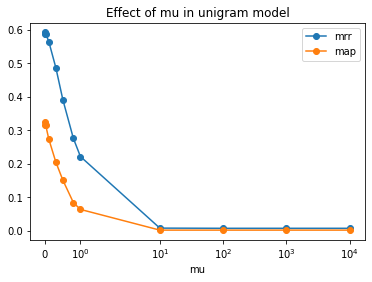

In [14]:
fig, ax = plt.subplots()

exp_df = pd.DataFrame(experiments, columns=['mu', 'mrr', 'map'])
ax.plot(exp_df['mu'], exp_df['mrr'], 'o-', label='mrr')
ax.plot(exp_df['mu'], exp_df['map'], 'o-', label='map')
plt.xlabel('mu')
plt.xscale("symlog")
ax.legend()
plt.title('Effect of mu in unigram model')
plt.show()

In [15]:
MU = 1e-4

#### Document Retrieval

In [16]:
np.random.seed(42)
test_qid1_grouped = test_df.groupby('qid1')
query_answer_unigram = dict()
unigram_document_retrieval, _ = get_unigram_document_retrieval(train_df, mu=MU)

sum_score = 0
for qid1 in tqdm(test_df.qid1.unique()):
    group = test_qid1_grouped.get_group(qid1)
    query = group['question1'].values[0]

    doc_scores = unigram_document_retrieval(query)
    ret_doc_ids = doc_scores.sort_values(by='score', ascending=False).doc_id.values.tolist()
    query_answer_unigram[qid1] = ret_doc_ids

100%|██████████| 146/146 [00:30<00:00,  4.74it/s]


### Question 2

#### Implementation

In [17]:
class Bigram:
    def __init__(self, document):
        n = 2 # Bi-gram

        train_seq = re.split('\W+', document.lower())
        grams = [tuple(train_seq[i:i+n]) for i in range(len(train_seq)-n+1)]
        gram_count = pd.DataFrame(Counter(grams).items(), columns=['gram', 'count'])
        gram_count[['pred', 'succ']] = pd.DataFrame(gram_count['gram'].tolist(), index=gram_count.index)

        self.model = {}
        group = gram_count.groupby('pred')
        for word in gram_count.pred.unique():
            self.model[word] = dict(group.get_group(word)[['succ', 'count']].values)

    def __getitem__(self, bigram):
        pred, succ = bigram

        numenator = self.model[pred].get(succ, 0) if pred in self.model else 0
        denumenator = sum(self.model[pred].values()) if pred in self.model else 0

        P_bi = 0
        if numenator or denumenator:
            P_bi = numenator/denumenator

        return P_bi

In [18]:
def get_bigram_document_retrieval(train_docs, P_uni, lambda_):
    n = 2 # Bi-gram
    P_bi = dict()
    for _, (doc_id, doc) in train_docs[['qid2', 'question2']].iterrows():
        if doc_id in P_bi:
            continue
        P_bi[doc_id] = Bigram(doc)

    def bigram_document_retrieval(query, interested_doc_ids=None):
        query_words = re.split('\W+', query.lower())
        query_grams = [tuple(query_words[i:i+n]) for i in range(len(query_words)-n+1)]
        results = list()
        for doc_id in P_bi:
            if interested_doc_ids and doc_id not in interested_doc_ids:
                continue

            log_prob = 0
            for i, gram in enumerate(query_grams):
                if i == 0:
                    log_prob += np.log(P_uni[doc_id][gram[0]])
                prob = lambda_ * P_bi[doc_id][gram] + (1 - lambda_) * P_uni[doc_id][gram[1]]
                if prob > 0:
                    log_prob += np.log(prob)

            results.append((doc_id, log_prob))
        return pd.DataFrame(results, columns=['doc_id', 'score']).sort_values('score', ascending=False)

    return bigram_document_retrieval, P_bi

#### Experiements for finding best lambda

In [26]:
np.random.seed(42)
experiments = list()
_, P_uni = get_unigram_document_retrieval(train_df, mu=MU)
val_qid1_grouped = val_df.groupby('qid1')

for lambda_ in (pbar := tqdm([1e-2, 1e-1, 0.3, 0.5, 0.8, 0.9, 0.99])):
    pbar.set_description(f"Experimenting with lambda = {lambda_:.2f}")
    bigram_document_retrieval, _ = get_bigram_document_retrieval(train_df, P_uni=P_uni, lambda_=lambda_)

    query_answer_val_bigram = dict()
    for qid1 in val_df.qid1.unique():
        group = val_qid1_grouped.get_group(qid1)
        query = group['question1'].values[0]

        doc_scores = bigram_document_retrieval(query)
        ret_doc_ids = doc_scores.sort_values(by='score', ascending=False).doc_id.values.tolist()
        query_answer_val_bigram[qid1] = ret_doc_ids

    mrr = MRR(query_answer_val_ref, query_answer_val_bigram)
    map_ = MAP(query_answer_val_ref, query_answer_val_bigram)
    experiments.append((lambda_, mrr, map_))

Experimenting with lambda = 0.99: 100%|██████████| 7/7 [20:34<00:00, 176.35s/it]


In [27]:
writer = MarkdownTableWriter(
    table_name="Effect of lambda in bigram model",
    headers=["lambda", "mrr", "map"],
    value_matrix=experiments
)
writer.write_table()

# Effect of lambda in bigram model
|lambda|       mrr        |        map        |
|-----:|-----------------:|------------------:|
|  0.01|0.5856472055908599|0.32362292415642970|
|  0.10|0.5826953716531026|0.32367633076379230|
|  0.30|0.6035455926920922|0.33523036621569097|
|  0.50|0.5963322027886059|0.32785460046519750|
|  0.80|0.5955713140140096|0.33376106382927956|
|  0.90|0.5912546192364615|0.32454613383524750|
|  0.99|0.5841155490231528|0.32336648232795300|


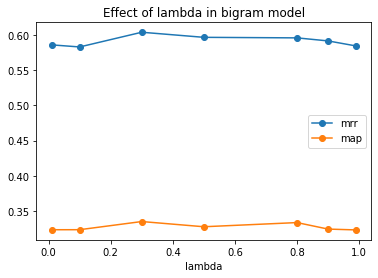

In [28]:
fig, ax = plt.subplots()

exp_df = pd.DataFrame(experiments, columns=['lambda', 'mrr', 'map'])
ax.plot(exp_df['lambda'], exp_df['mrr'], 'o-', label='mrr')
ax.plot(exp_df['lambda'], exp_df['map'], 'o-', label='map')
plt.xlabel('lambda')
ax.legend()
plt.title('Effect of lambda in bigram model')
plt.show()

In [19]:
LAMBDA = 0.3

#### Document Retrieval

In [20]:
np.random.seed(42)
test_qid1_grouped = test_df.groupby('qid1')
query_answer_bigram = dict()
_, P_uni = get_unigram_document_retrieval(train_df, mu=MU)
bigram_document_retrieval, _ = get_bigram_document_retrieval(train_df, P_uni=P_uni, lambda_=LAMBDA)

sum_score = 0
for qid1 in tqdm(test_df.qid1.unique()):
    group = test_qid1_grouped.get_group(qid1)
    query = group['question1'].values[0]

    doc_scores = bigram_document_retrieval(query)
    ret_doc_ids = doc_scores.sort_values(by='score', ascending=False).doc_id.values.tolist()
    query_answer_bigram[qid1] = ret_doc_ids

100%|██████████| 146/146 [00:47<00:00,  3.08it/s]


## Part 4

#### Evaluating TF-IDF Retrieval

In [21]:
map_ = MAP(ref_set=query_answer_ref, pred_set=query_answer_tfidf)
mrr = MRR(ref_set=query_answer_ref, pred_set=query_answer_tfidf)
avg_p_at_5 = AP(ref_set=query_answer_ref, pred_set=query_answer_tfidf, k=5)
avg_p_at_10 = AP(ref_set=query_answer_ref, pred_set=query_answer_tfidf, k=10)
print('map=', map_)
print('mrr=', mrr)
print('ap@5=', avg_p_at_5)
print('ap@10=', avg_p_at_10)

map= 0.4703838136898951
mrr= 0.7441373124592316
ap@5= 0.4945205479452046
ap@10= 0.3589041095890413


#### Evaluating Unigram Retrieval

In [22]:
map_ = MAP(ref_set=query_answer_ref, pred_set=query_answer_unigram)
mrr = MRR(ref_set=query_answer_ref, pred_set=query_answer_unigram)
avg_p_at_5 = AP(ref_set=query_answer_ref, pred_set=query_answer_unigram, k=5)
avg_p_at_10 = AP(ref_set=query_answer_ref, pred_set=query_answer_unigram, k=10)
print('map=', map_)
print('mrr=', mrr)
print('ap@5=', avg_p_at_5)
print('ap@10=', avg_p_at_10)

map= 0.3824867983300586
mrr= 0.7505467872137588
ap@5= 0.41780821917808164
ap@10= 0.29999999999999993


### Evaluating Bigram Retrieval

In [23]:
map_ = MAP(ref_set=query_answer_ref, pred_set=query_answer_bigram)
mrr = MRR(ref_set=query_answer_ref, pred_set=query_answer_bigram)
avg_p_at_5 = AP(ref_set=query_answer_ref, pred_set=query_answer_bigram, k=5)
avg_p_at_10 = AP(ref_set=query_answer_ref, pred_set=query_answer_bigram, k=10)
print('map=', map_)
print('mrr=', mrr)
print('ap@5=', avg_p_at_5)
print('ap@10=', avg_p_at_10)

map= 0.3835266783761814
mrr= 0.7551675384465015
ap@5= 0.41780821917808153
ap@10= 0.29452054794520544
